##Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.8.0


##Custom Model

###Data Load

In [3]:
train_dir = os.path.join('/content/drive/Shared with me/Flowers/train')
validation_dir = os.path.join('/content/drive/Shared with me/Flowers/valid')

In [4]:
BATCH_SIZE = 16
EPOCHS=15
IMG_SIZE = (224, 224)

####Using Image Generator

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # set each sample mean to 0
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.2,  # Randomly zoom image
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,
    fill_mode='nearest',
) 
valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# load and iterate training dataset
train_it = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Flowers/train/",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
    save_to_dir='/content/drive/MyDrive/Flowers/Augmentedimages/train',
)
# load and iterate validation dataset
valid_it = valid_datagen.flow_from_directory(
  "/content/drive/MyDrive/Flowers/valid/",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
    save_to_dir='/content/drive/MyDrive/Flowers/Augmentedimages/valid'
)

Found 289 images belonging to 10 classes.
Found 46 images belonging to 10 classes.


In [7]:
classes=train_it.class_indices
classes

{'Artemisia Pallens': 0,
 'Celosia Argentia': 1,
 'Centella asiatica': 2,
 'Chloris Barbata': 3,
 'Clitoria Ternatea': 4,
 'Dactyloctenium Angyptium': 5,
 'Gomphrena Globosa': 6,
 'Hibiscus rosa-sinensis': 7,
 'Ixora Coccinea': 8,
 'Vitex Negundo': 9}

In [8]:
for image_batch, labels_batch in train_it:
  print(image_batch.shape)
  print(labels_batch[0].shape)
  break

OSError: ignored

####Using Image Dataset from Directory

In [ ]:
train_dataset = keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical'
                                                            )

valid_dataset = keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical'
                                                            )

Found 289 files belonging to 10 classes.
Found 46 files belonging to 10 classes.


In [ ]:
classes=train_dataset.class_names
[classes]

[['Artemisia Pallens',
  'Celosia Argentia',
  'Centella asiatica',
  'Chloris Barbata',
  'Clitoria Ternatea',
  'Dactyloctenium Angyptium',
  'Gomphrena Globosa',
  'Hibiscus rosa-sinensis',
  'Ixora Coccinea',
  'Vitex Negundo']]

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of valid batches: %d' % tf.data.experimental.cardinality(valid_dataset))

Number of train batches: 19
Number of valid batches: 3


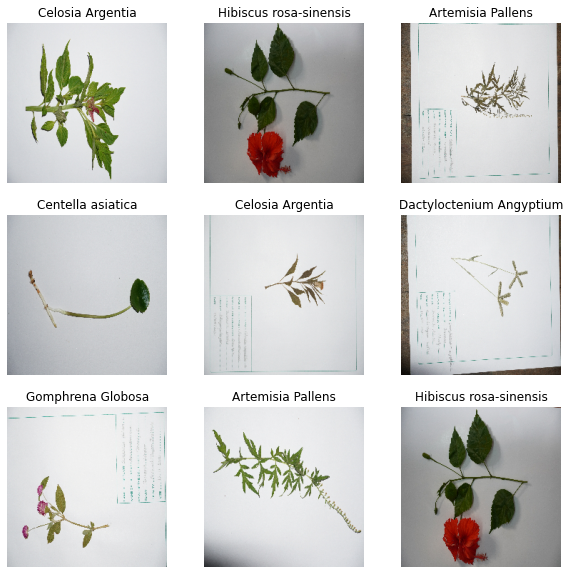

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
normalization_layer = keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
train_dataset = train_dataset.cache()
valid_dataset = valid_dataset.cache()

In [ ]:
train_dataset.repeat()
valid_dataset.repeat()

<RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

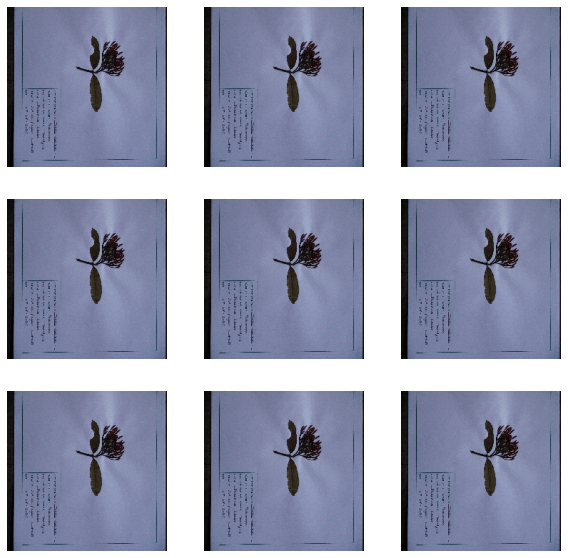

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

###Training Code

In [ ]:
def conv_block(filters):
    
    block = keras.Sequential([
        
        keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D()
        
    ])
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    
    block = keras.Sequential([
        
        keras.layers.Dense(units, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(dropout_rate)
        
    ])
    
    return block

In [ ]:
def data_aug():
    
    block = tf.keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomFlip('vertical'),
  keras.layers.RandomRotation(0.2),
  keras.layers.RandomZoom(0.2),
])
    
    return block

In [ ]:
def build_model_1():
    model = keras.Sequential([
        
        keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        
        data_aug(),
        
        keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        keras.layers.Dropout(0.2),
        
        conv_block(256),
        keras.layers.Dropout(0.2),
        
        keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        keras.layers.Dense(10, activation='softmax')
        
    ])
    
    return model

In [ ]:
def build_model_2():
    model = keras.Sequential([
        
        keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        
        keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        keras.layers.Dropout(0.2),
        
        conv_block(256),
        keras.layers.Dropout(0.2),
        
        keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        keras.layers.Dense(10,activation='softmax')
        
    ])
    
    return model

In [ ]:
with strategy.scope():
    
    model_aug = build_model_1()
    model = build_model_2()

    METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(0.003),
        loss=keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=METRICS
    )
    model_aug.compile(
        optimizer=keras.optimizers.Adam(0.003),
        loss=keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=METRICS
    )

In [ ]:
model.summary()

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_23 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 sequential_94 (Sequential)  (None, 56, 56, 32)        2160      
                                                                 
 sequential_95 (Sequential)  (None, 28, 28, 64)        7392      
                                                                 
 sequential_96 (Sequential)  (None, 14, 14, 128)       27072     
                                                    

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("custom_flower_model.h5",
                                                    save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.003, 20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
int(np.ceil(289 // float(BATCH_SIZE)))

18

In [ ]:
hist = model.fit(
    train_it,
    batch_size=BATCH_SIZE,
    shuffle=True,
    steps_per_epoch=18,
    epochs=45,
    validation_data=valid_it,
    validation_steps=2,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/45
18/18 [==============================] - 149s 8s/step - loss: 2.7530 - accuracy: 0.1612 - precision: 0.2027 - recall: 0.0549 - val_loss: 2.3165 - val_accuracy: 0.1562 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0030
Epoch 2/45
18/18 [==============================] - 141s 8s/step - loss: 2.5497 - accuracy: 0.1538 - precision: 0.2817 - recall: 0.0733 - val_loss: 2.3819 - val_accuracy: 0.0625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0027
Epoch 3/45
18/18 [==============================] - 141s 8s/step - loss: 2.5265 - accuracy: 0.1868 - precision: 0.2812 - recall: 0.0989 - val_loss: 2.3911 - val_accuracy: 0.0938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0024
Epoch 4/45
18/18 [==============================] - 139s 8s/step - loss: 2.2044 - accuracy: 0.2381 - precision: 0.3714 - recall: 0.0952 - val_loss: 2.4724 - val_accuracy: 0.0625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0021
Epoch 5/45
18/18 [======

In [ ]:
dont use the below code

In [ ]:
hist_2 = model_aug.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    epochs=15,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/15
19/19 [==============================] - 15s 531ms/step - loss: 2.8551 - accuracy: 0.1626 - precision: 0.2391 - recall: 0.0761 - val_loss: 2.3932 - val_accuracy: 0.1087 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0030
Epoch 2/15
19/19 [==============================] - 3s 176ms/step - loss: 2.5457 - accuracy: 0.2042 - precision: 0.2099 - recall: 0.0588 - val_loss: 2.3347 - val_accuracy: 0.1087 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0027
Epoch 3/15
19/19 [==============================] - 3s 148ms/step - loss: 2.1382 - accuracy: 0.2561 - precision: 0.3409 - recall: 0.1038 - val_loss: 2.5071 - val_accuracy: 0.1087 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0024
Epoch 4/15
19/19 [==============================] - 3s 148ms/step - loss: 1.9976 - accuracy: 0.3253 - precision: 0.4639 - recall: 0.1557 - val_loss: 2.6227 - val_accuracy: 0.1087 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0021
Epoch 5/15
19/19 [=

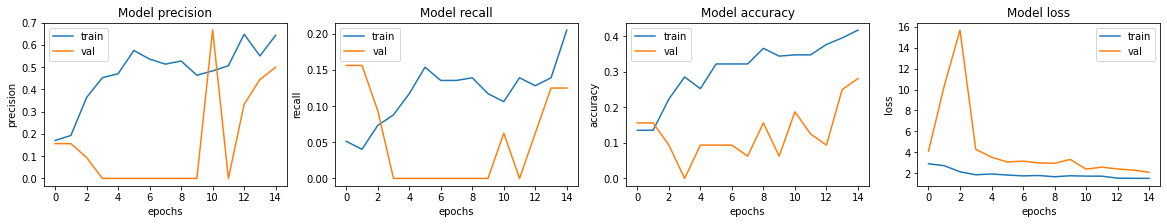

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model.save('./Custom_tf_03',save_format='tf')

INFO:tensorflow:Assets written to: ./Custom_tf_03/assets


In [ ]:
!zip -r custom_flower.zip {'./Custom_tf_03'}

  adding: Custom_tf_03/ (stored 0%)
  adding: Custom_tf_03/variables/ (stored 0%)
  adding: Custom_tf_03/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: Custom_tf_03/variables/variables.index (deflated 72%)
  adding: Custom_tf_03/assets/ (stored 0%)
  adding: Custom_tf_03/keras_metadata.pb (deflated 96%)
  adding: Custom_tf_03/saved_model.pb (deflated 90%)


In [ ]:
!unzip "/content/drive/MyDrive/Flowers/Models/custom_flower.zip" -d "/content/drive/MyDrive/Flowers/Models"

Archive:  /content/drive/MyDrive/Flowers/Models/custom_flower.zip
   creating: /content/drive/MyDrive/Flowers/Models/Custom_tf_01/
   creating: /content/drive/MyDrive/Flowers/Models/Custom_tf_01/assets/
   creating: /content/drive/MyDrive/Flowers/Models/Custom_tf_01/variables/
  inflating: /content/drive/MyDrive/Flowers/Models/Custom_tf_01/variables/variables.index  
  inflating: /content/drive/MyDrive/Flowers/Models/Custom_tf_01/variables/variables.data-00000-of-00001  
  inflating: /content/drive/MyDrive/Flowers/Models/Custom_tf_01/saved_model.pb  
  inflating: /content/drive/MyDrive/Flowers/Models/Custom_tf_01/keras_metadata.pb  


In [ ]:
model_loaded=tf.keras.models.load_model('/content/drive/MyDrive/Flowers/Models/Custom_tf_01')

In [ ]:
from tensorflow.python.ops.gen_math_ops import arg_max
from PIL import Image
import cv2

In [ ]:
path="/content/drive/MyDrive/Flowers/inference/centella-asiatica-500x500.jpg"
img= cv2.imread(path)
a=(224,224)

In [ ]:
img.shape

(334, 500, 3)

In [ ]:
img = cv2.resize(img,a)
img.shape

(224, 224, 3)

In [ ]:
def get_key(val):
    for key, value in classes.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [ ]:
img_arr=tf.keras.utils.img_to_array(img)
img_arr=tf.expand_dims(img_arr,0)
pred=model.predict(img_arr)
score = tf.nn.softmax(pred[0])
score

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.10461272, 0.1009278 , 0.09233396, 0.09514832, 0.10201087,
       0.10277857, 0.10277397, 0.09901669, 0.09650907, 0.10388803],
      dtype=float32)>

In [ ]:
print("Output class : ",get_key(np.argmax(score))," Percent : ",100*np.max(score))

Output class :  Artemisia Pallens  Percent :  10.461272299289703


##Transfer Model

###Extra

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',classifier_activation=None)

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_10[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(len(classes))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 10)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(valid_dataset)

3/3 [==============================] - 20s 208ms/step - loss: 2.7719 - accuracy: 0.1087


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.64
initial accuracy: 0.11


In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("flower_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]

In [ ]:
history = model.fit(train_it,
                    epochs=25,
                    validation_data=valid_it,
                    callbacks=[checkpoint_cb]
                    )

Epoch 1/25
37/37 [==============================] - 135s 4s/step - loss: 2.5033 - accuracy: 0.1211 - val_loss: 2.3173 - val_accuracy: 0.1522
Epoch 2/25
37/37 [==============================] - 126s 3s/step - loss: 2.4664 - accuracy: 0.0830 - val_loss: 2.3598 - val_accuracy: 0.1087
Epoch 3/25
37/37 [==============================] - 128s 3s/step - loss: 2.5006 - accuracy: 0.0657 - val_loss: 2.3029 - val_accuracy: 0.1087
Epoch 4/25
37/37 [==============================] - 127s 3s/step - loss: 2.4834 - accuracy: 0.0830 - val_loss: 2.3337 - val_accuracy: 0.1087
Epoch 5/25
37/37 [==============================] - 127s 3s/step - loss: 2.4512 - accuracy: 0.1038 - val_loss: 2.2610 - val_accuracy: 0.1087
Epoch 6/25
37/37 [==============================] - 126s 3s/step - loss: 2.4379 - accuracy: 0.1107 - val_loss: 2.3008 - val_accuracy: 0.0652
Epoch 7/25
37/37 [==============================] - 128s 3s/step - loss: 2.4422 - accuracy: 0.1038 - val_loss: 2.3401 - val_accuracy: 0.1739
Epoch 8/25
37

KeyboardInterrupt: ignored

In [ ]:
history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=valid_dataset,
                    callbacks=[checkpoint_cb]
                    )

Epoch 1/25
19/19 [==============================] - 50s 2s/step - loss: 2.5248 - accuracy: 0.0934 - val_loss: 2.3779 - val_accuracy: 0.1087
Epoch 2/25
19/19 [==============================] - 1s 41ms/step - loss: 2.4844 - accuracy: 0.0969 - val_loss: 2.3945 - val_accuracy: 0.1087
Epoch 3/25
19/19 [==============================] - 1s 56ms/step - loss: 2.4003 - accuracy: 0.1003 - val_loss: 2.3611 - val_accuracy: 0.1087
Epoch 4/25
19/19 [==============================] - 1s 57ms/step - loss: 2.4327 - accuracy: 0.0761 - val_loss: 2.3539 - val_accuracy: 0.1087
Epoch 5/25
19/19 [==============================] - 1s 37ms/step - loss: 2.4226 - accuracy: 0.0934 - val_loss: 2.3708 - val_accuracy: 0.1087
Epoch 6/25
19/19 [==============================] - 1s 56ms/step - loss: 2.3877 - accuracy: 0.1246 - val_loss: 2.3161 - val_accuracy: 0.1087
Epoch 7/25
19/19 [==============================] - 1s 56ms/step - loss: 2.3934 - accuracy: 0.1142 - val_loss: 2.3036 - val_accuracy: 0.1087
Epoch 8/25
19/

In [ ]:
base_model = keras.applications.resnet50.ResNet50(
    weights='imagenet', 
    input_shape=(224, 224, 3),
    include_top=False)

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

###Freeze the model

In [ ]:
base_model.trainable = False

###Create Model

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


###Data Augmentation

In [ ]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=int(train_it.samples/train_it.batch_size),
          validation_steps=int(valid_it.samples/valid_it.batch_size),
          epochs=10)

Epoch 1/10
36/36 [==============================] - 300s 8s/step - loss: 9.3979 - accuracy: 0.0000e+00 - val_loss: 10.7157 - val_accuracy: 0.0000e+00
Epoch 2/10
36/36 [==============================] - 132s 4s/step - loss: 10.8678 - accuracy: 0.0000e+00 - val_loss: 11.3766 - val_accuracy: 0.0000e+00
Epoch 3/10
36/36 [==============================] - 132s 4s/step - loss: 10.1090 - accuracy: 0.0000e+00 - val_loss: 9.2853 - val_accuracy: 0.0000e+00
Epoch 4/10
36/36 [==============================] - 131s 4s/step - loss: 11.0339 - accuracy: 0.0000e+00 - val_loss: 12.4915 - val_accuracy: 0.0000e+00
Epoch 5/10
36/36 [==============================] - 131s 4s/step - loss: 11.1877 - accuracy: 0.0000e+00 - val_loss: 10.4768 - val_accuracy: 0.0000e+00
Epoch 6/10
36/36 [==============================] - 131s 4s/step - loss: 10.7847 - accuracy: 0.0000e+00 - val_loss: 10.8929 - val_accuracy: 0.0000e+00
Epoch 7/10
36/36 [==============================] - 132s 4s/step - loss: 11.9341 - accuracy: 0.0

KeyboardInterrupt: ignored